In [1]:
import sys as _sys
import os

current_path = os.path.abspath(os.getcwd())

split = current_path.split("sgi_igl")
if len(split)<2:
    print("Please rename the repository 'sgi_igl'")
    raise ValueError
path_to_python_scripts = os.path.join(split[0], "sgi_igl/python/")
path_to_notifications = os.path.join(split[0], "sgi_igl/notebooks/notifications/")
path_to_settings = os.path.join(split[0], "sgi_igl/python/figures/")
path_to_cubic_splines = os.path.join(split[0], "sgi_igl/ext/torchcubicspline/")
path_to_data = os.path.join(split[0], "sgi_igl/output/")
path_to_save = os.path.join(split[0], "sgi_igl/output/snake_all_joints")

_sys.path.insert(0, path_to_python_scripts)
_sys.path.insert(0, path_to_settings)
_sys.path.insert(0, path_to_cubic_splines)

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import shutil
import torch

from physics_quantities_torch_edge import vmap_energy_torch
from utils import vmap_euc_transform_torch, vmap_euc_transform_T_torch
from vis_utils import produce_video_from_path
from vis_utils_snake import plot_animated_snake, print_json_data

In [3]:
exp_file_names = [
    "snake_all_joints/snake_all_joints_opt_00.json",
    "snake_all_joints/snake_all_joints_opt_01.json",
]

list_js_loads = []
for exp_file_name in exp_file_names:
    with open(os.path.join(path_to_data, exp_file_name)) as jsonFile:
        js_load = json.load(jsonFile)

    print(exp_file_name)
    print_json_data(js_load)
    print()
    list_js_loads.append(js_load)

snake_all_joints/snake_all_joints_opt_00.json
Number of timesteps:  80
Number of vertices:  11
Number of control points not available.
Is it a closed gate:  True
Number of modes is not available.
Optimization duration (min:sec): 00:44

snake_all_joints/snake_all_joints_opt_01.json
Number of timesteps:  80
Number of vertices:  11
Number of control points not available.
Is it a closed gate:  True
Number of modes is not available.
Optimization duration (min:sec): 02:01



In [4]:
list_energies = []
for js_load in list_js_loads:

    pos_ = torch.tensor(js_load['pos_'])
    pos = torch.tensor(js_load['pos'])
    n_points_snake = pos.shape[1]
    n_ts = pos.shape[0]
    g = torch.tensor(js_load['g'])
    gt = torch.tensor(js_load['optimization_settings']['gt'])
    params_opt = torch.tensor(js_load['optimization_settings']['params_opt'])
    rho = js_load['optimization_settings']['rho']
    eps = js_load['optimization_settings']['eps']
    edges = np.array(js_load['optimization_settings']["edges"])
    edges_torch = torch.tensor(edges)
    n_edges = edges.shape[0]
    def fun_anisotropy_dir(x):
        tangents = x[..., edges_torch[:, 1], :] - x[..., edges_torch[:, 0], :]
        tangents = tangents / torch.linalg.norm(tangents, dim=-1, keepdims=True)
        return tangents

    tangents_ = fun_anisotropy_dir(pos_)
    pos = vmap_euc_transform_torch(g, pos_)
    tangents = vmap_euc_transform_T_torch(g, tangents_)
    edge_lengths = torch.linalg.norm(pos_[:, 1:] - pos_[:, :-1], dim=-1)
    masses = rho * edge_lengths
    a_weights = torch.ones(size=(n_ts, n_edges))
    b_weights = (eps - 1.0) * torch.ones(size=(n_ts, n_edges))

    energies = vmap_energy_torch(
        pos[:-1], pos[1:], tangents[:-1], tangents[1:], 
        masses[:-1], masses[1:], a_weights[:-1], a_weights[1:], 
        b_weights[:-1], b_weights[1:], torch.tensor(edges)
    )
    list_energies.append(energies)


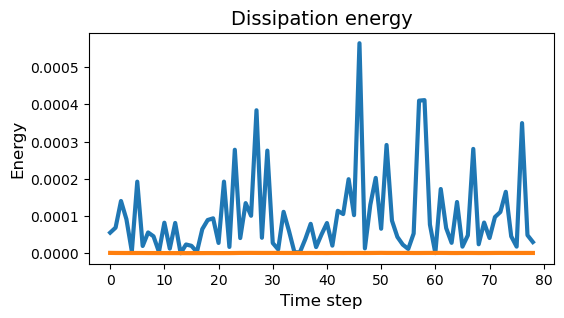

In [5]:
fig = plt.figure(figsize=(6, 3))
gs = fig.add_gridspec(1, 1)
ax_tmp = fig.add_subplot(gs[0, 0])
for energies in list_energies:
    ax_tmp.plot(energies, lw=3.0, zorder=0)
ax_tmp.set_title("Dissipation energy", fontsize=14)
ax_tmp.set_xlabel("Time step", fontsize=12)
ax_tmp.set_ylabel("Energy", fontsize=12)
plt.show()

In [8]:
trial_id = 0
js_load = list_js_loads[trial_id]
pos_plot = np.array(js_load['pos'])
g_plot = np.array(js_load['g'])

path_to_images_anim = os.path.join(path_to_save, "images_registered")
arrow_params = {
    "length": 0.05,
    "width": 0.02,
}

# clear existing images
if os.path.exists(path_to_images_anim):
    shutil.rmtree(path_to_images_anim)
os.makedirs(path_to_images_anim)

plot_animated_snake(
    pos_plot, path_to_images_anim,
    g=g_plot, gt=gt, gcp=None,
    exponent=1.0, xy_lim=None, 
    show_orientation=False, show_snake_trail=False, 
    show_g_trail=True, show_g_start=True,
    arrow_params=arrow_params,
)

Images saved to /Users/quentinbecker/Research/sgi_igl/output/snake_all_joints/images_registered


In [7]:
fn_pattern = os.path.join(path_to_images_anim, "step_%05d.png")
produce_video_from_path(
    fn_pattern, path_to_save, 
    "all_joints_{:02d}_pos.mp4".format(trial_id), overwrite_anim=True, transparent=False
)

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/miniconda3/envs/sgi_igl_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16.100 /